## Settings

In [1]:
import os
from os.path import join as osj
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import numpy as np
import json
from workoutdetector.datasets import RepcountHelper

In [8]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.autolayout'] = True
plt.style.use('dark_background')
plt.rcParams['lines.linewidth'] = 0.8
COLORS = list(plt.get_cmap('Set3').colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', COLORS)
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 300

In [3]:
helper = RepcountHelper('../data/RepCount/', '../data/RepCount/annotation.csv') 
info = helper.get_rep_data(['test'], action=['all'])
CLASSES = helper.classes
print(CLASSES)

['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']


## Image model

In [ ]:
json_files = [x for x in os.listdir('../out/pred_no_bbox/') if x.endswith('.json')]
json_iter = iter(json_files)

In [ ]:
json_file = next(json_iter)
name = json_file.split('-')[0]
print(name)
example = json.load(open(f'../out/pred_no_bbox/{name}-score.json'))
scores = np.asarray([v for _, v in example['scores'].items()])
print('total frames', len(scores))
print('reps', info[name].reps)

plt.plot(F.softmax(torch.Tensor(scores), dim=1))
plt.vlines(x=info[name].reps, color='C2', ymin=0.4, ymax=0.6)
plt.title(f'{name} {info[name].class_} Count={info[name].count}', color='C0', fontsize=12)
plt.show()

## Video model

In [ ]:
video_save_dir = '../out/tsm_rep_scores_dense_sample'
video_json = os.listdir(video_save_dir)
print(video_json[0])
video_iter = iter(video_json)

### Label

In [ ]:
x = next(video_iter)
j = json.load(open(osj(video_save_dir, x)))
scores = np.asarray(list(j['scores'].values()))
scores

### Scores

sparse sample is sampling 8 frames from 16 frames uniformly. Step is 8.

In [ ]:
video_save_dir = '../out/tsm_rep_scores_sparse_sample'
video_json = os.listdir(video_save_dir)
print(video_json[0])
valtest = helper.get_rep_data(['val', 'test'], action=['all']).values()
video_iter = iter(valtest)

In [ ]:
x = next(video_iter)
json_path = x.video_name + '.score.json'
j = json.load(open(osj(video_save_dir, json_path)))
print(j['video_name'])
gt_reps = np.array(j['ground_truth'])

In [ ]:
def plot_all(gt_reps: np.ndarray, info: dict):
    total_frames = j['total_frames']
    ys = []
    for item in list(j['scores'].values()):
        ys.append([item[str(j)] if str(j) in item else 0 for j in range(12)])
    ys = np.asarray(ys)
    counts = len(gt_reps) // 2
    GT_CLASS_INDEX = CLASSES.index(info['action'])
    COLORS = list(plt.get_cmap('Set3').colors)
    plt.plot(ys, marker='.', linestyle='None')
    plt.xticks(range(0, total_frames//8, total_frames//80))
    plt.xlabel('Frame index')
    plt.ylabel('Softmax score')
    plt.title(f"{info['video_name']} {info['action']} count={counts}")
    plt.ylim(0, 1.1)
    plt.vlines(x=gt_reps[0::2]//8, color=COLORS[GT_CLASS_INDEX*2], ymin=0.51, ymax=1.0)
    plt.vlines(x=gt_reps[1::2]//8, color=COLORS[GT_CLASS_INDEX*2+1], ymin=0.0, ymax=0.49)
    plt.legend(np.array(CLASSES).repeat(2))

    # Indicator
    segs = []
    HEIGHT = 1.01
    for i in range(len(gt_reps[::2])):
        start = gt_reps[i*2]
        end = gt_reps[i*2+1]
        mid = (start + end) // 2
        segs.append([(start//8, HEIGHT), (mid//8, HEIGHT)])
        segs.append([(mid//8, HEIGHT), (end//8, HEIGHT)])
    lc = LineCollection(segs, colors=[COLORS[GT_CLASS_INDEX*2], COLORS[GT_CLASS_INDEX*2+1]], linewidths=1)
    plt.gca().add_collection(lc)
    plt.show()

def plot_per_action(CLASSES: list, info: dict):
    total_frames = j['total_frames']
    ys = []
    for item in list(j['scores'].values()):
        ys.append([item[str(j)] if str(j) in item else 0 for j in range(12)])
    ys = np.asarray(ys)
    fig, ax = plt.subplots(len(CLASSES), 1, figsize=(8, 8))
    for idx in range(len(CLASSES)):
        ax[idx].set_ylim(0, 1.1)
        ax[idx].plot(ys[:, idx*2:idx*2+2])
        ax[idx].set_title(f'{CLASSES[idx]}', y=0.95)
        ax[idx].set_xticks(range(0, total_frames//8, total_frames//80))
    plt.xlabel('Frame index')
    plt.ylabel('Softmax score')
    plt.show()

## Count

In [4]:
from workoutdetector.utils.inference_count import pred_to_count, write_to_video
from workoutdetector.utils import plot_all, plot_per_action, plot_pred

In [6]:
video_save_dir = '../out/tsm_lightning_sparse_sample/'
video_json = os.listdir(video_save_dir)
print(video_json[0])
valtest = helper.get_rep_data(['val', 'test'], action=['all']).values()
video_iter = iter(valtest)

stu6_25.mp4.score.json


stu5_32.mp4
[-1, 4, 4, 5, 5, 4, 4, 5, 5, 4, 4, -1, 5, 4, 4, -1, 5, -1, 4, -1, 5, -1, 4, 4, 5, 5, 4, 4, -1, 5, 4, 4, 7, 5, -1, 4, 4, 5, 5, 4, 4, -1, 5, -1, 4, -1, 5, -1, 4, 4, -1, 5, 4, 4, -1, 5, -1, 4, 4, 5, 5, 4, 4, -1, 5, -1, 4, 4, 5, 5, 4, 4, -1, 5, -1, 4, 4, 5, 5, 4, 4, -1, 5, 4, 4, 4, 5, 5, 4, 4, -1, 5, -1, 4, 4, 5, 5, 4, 4, -1, 5, -1, 4, 4, -1, 5, 4, 4, 4, 5, 5, 4, 4, 7, 5, -1, 4, 4, -1, 5, 4, 4, -1, 5, 5, 4, 4, 4, 5, -1, 4, 4, -1, -1, -1]
[8, 24, 40, 56, 72, 96, 104, 128, 144, 160, 176, 192, 208, 232, 280, 296, 312, 336, 352, 368, 384, 408, 416, 440, 456, 472, 488, 512, 528, 544, 560, 584, 600, 616, 632, 656, 664, 688, 704, 728, 744, 760, 776, 800, 816, 840, 848, 872, 928, 952, 960, 984, 1000, 1024]
gt=30, pred=27
Absolute diff 3


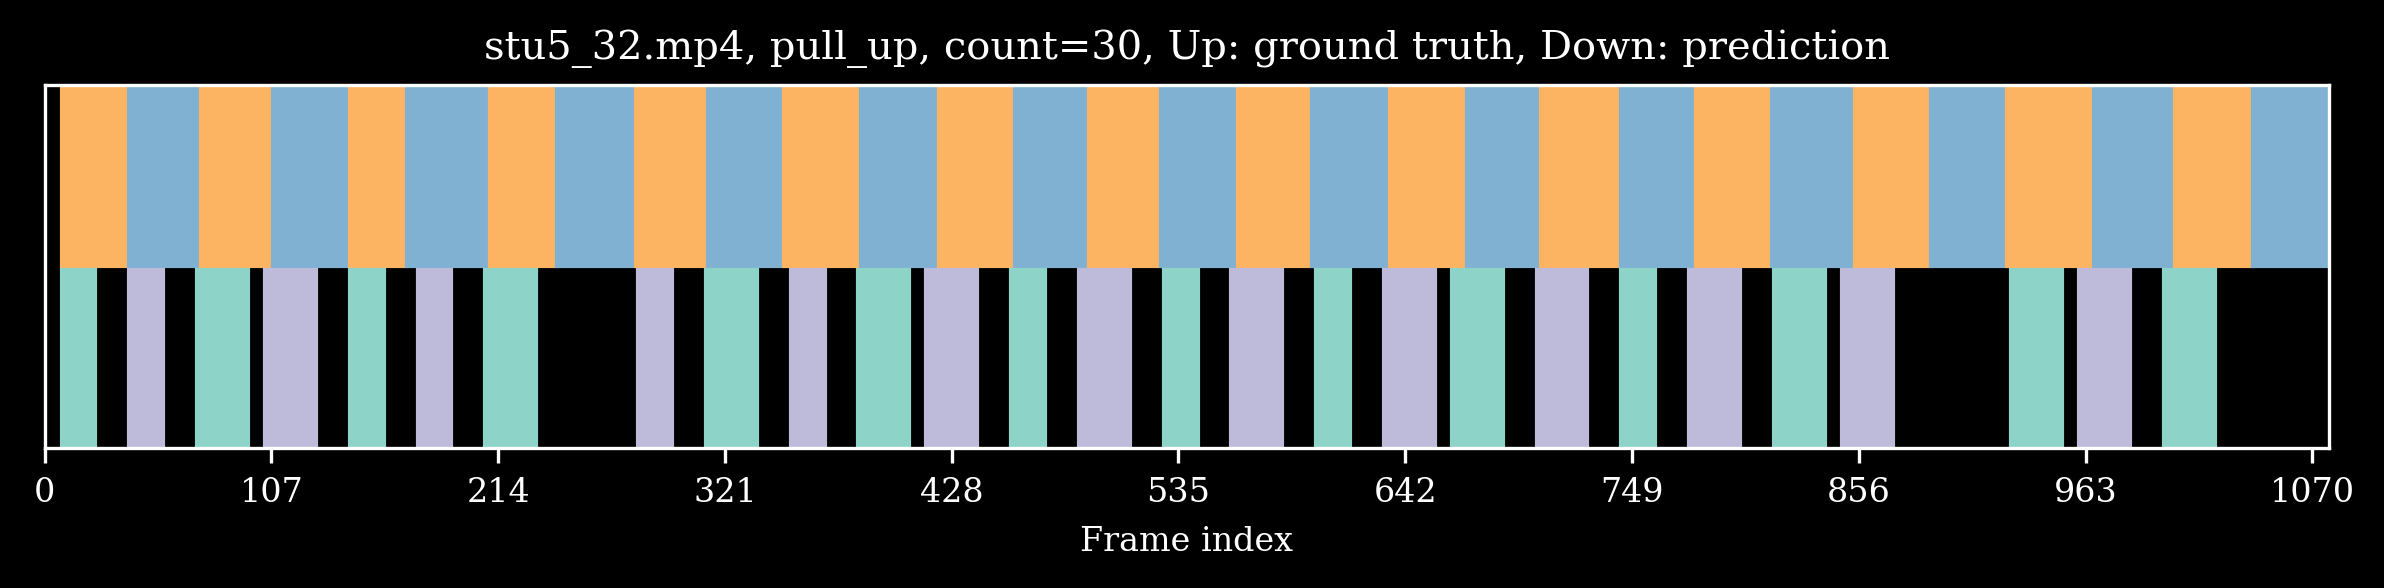

In [174]:
x = next(video_iter)
json_path = x.video_name + '.score.json'
j = json.load(open(osj(video_save_dir, json_path)))
print(j['video_name'])
gt = np.array(j['ground_truth'])
score = j['scores']
threshold = 0.5
# print(score.values())
pred = []

for v in score.values():
    softmax_score = F.softmax(torch.Tensor(list(v.values())), dim=0)
    max_idx = torch.argmax(softmax_score)
    class_id, sc = max_idx.item(), softmax_score[max_idx].item()
    if sc >= threshold:
        pred.append(int(class_id))
    else:
        pred.append(-1)
print(pred)
result = pred_to_count(pred, step=8)
print(result[1])
print(f'gt={len(gt)//2}, pred={result[0]}')
print('Absolute diff', abs(result[0] - len(gt) // 2))

plot_pred(result[1], gt, j['total_frames'], info=j, step=8)
plot_all(gt, info=j, softmax=True)
plot_per_action(info=j, softmax=True)

write_to_video(video_path=os.path.join('/home/user/data/RepCount/videos', x.split, x.video_name),
               output_path=f'../out/{x.video_name}',
               reps=result[1],
               states=pred,
               step=8)
